#### **Import Libraries**

In [1]:
from typing import Tuple
import jax 
import jax.numpy as jnp
from jax import Array
from functools import partial 
from einops import rearrange, repeat
import optax 
from diffrax import diffeqsolve, ODETerm, Dopri5
from tqdm import tqdm 
from rfp import MLP, Model, ModelParams
from rfp.losses import Supervised_Loss, mse
from rfp.train import Trainer

#### **Path**

In [27]:
figure_folders = './../../../rfp_paper/figures/'

#### **Set Up Plotting**

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../styles/Newsreader
/home/ubuntu/rfp/styles/Newsreader/static/Newsreader_60pt/Newsreader_60pt-SemiBold.ttf


#### **Data Hyperparameters**

In [3]:
n = 20             
d = 4              
c = 20            
init_key = jax.random.PRNGKey(0)
nodes = 128 
lr = 1e-3
epochs = 100 

2024-05-18 17:43:55.833972: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


#### **Functions**

In [5]:
def value_to_key(value: float) -> jax.random.PRNGKey:
    # Scale value to the range of PRNG key integers
    max_int = jnp.iinfo(jnp.int32).max
    scaled_value = jnp.array(value * max_int, dtype=jnp.int32)

    # Create a new key using the scaled value
    key = jax.random.PRNGKey(scaled_value)
    return key

def original_function(x: Array) -> Array:
    key = value_to_key(x[3])
    a, b, c =  jax.random.choice(key, jnp.linspace(-5., 5., 1000), shape=(3,))
    return a * jnp.sin(x[0]) + b * jnp.cos(x[1]) + c * jnp.sin(jnp.cos(x[2])) ** 2

def integrand(x, t, y, args):
    x_with_x3 = jnp.array([x[0], x[1], x[2], t])
    return original_function(x_with_x3)*jax.scipy.stats.norm.pdf(t)

def integrated_function(x: Array) -> Array:
    x = x[:-1]
    term = ODETerm(partial(integrand, x))
    solver = Dopri5()
    y0 = jnp.array([0.])
    solution = diffeqsolve(term, solver, t0=-3., t1=3., dt0=0.1, y0=y0)
    return solution.ys[0]

#### **Sample Data**

In [6]:

def obs_sample(n: int, d: int, key: jax.random.PRNGKey) -> Tuple[Array, Array]:
    k1, k2 = jax.random.split(key, 2)
    
    # Generate multivariate normal samples
    xs = jax.random.multivariate_normal(k1, mean=jnp.zeros(d-1), cov=jnp.eye(d-1), shape=(n,))
    
    # Generate the cluster feature
    x_cluster_features = jax.random.uniform(k2, shape=(1,))
    
    # Repeat the cluster feature for each sample using einops
    x_cluster_features_repeated = repeat(x_cluster_features, '1 -> n 1', n=n)
    
    # Concatenate the cluster feature to the generated samples
    xs = jnp.hstack((xs, x_cluster_features_repeated))
    
    # Compute ys using the modified xs
    ys = jax.vmap(original_function)(xs).reshape(-1, 1) # + 0.1 * jax.random.normal(k2, shape=(n, 1))
    
    return xs, ys

@partial(jax.jit, static_argnums=(0,1))
def cluster_batch_sample(n, c, key):
    k1, k2 = jax.random.split(key)
    xs, ys = jax.vmap(partial(obs_sample, n, 4))(jax.random.split(k1, c))
    xs =  rearrange(xs, 'a b c -> (a b) c')
    ys = rearrange(ys, 'a b c -> (a b) c')
    # noise = 0.1*jax.random.normal(k2, (c, 1))
    # repeated_noise = repeat(noise, 'c 1 -> (n c)', n=n)
    # ys = ys + repeated_noise
    return xs, ys, jax.vmap(original_function)(xs).reshape(-1,1)

@partial(jax.jit, static_argnums=(0,1))
def iid_batch_sample(n, c, key):
    k1, k2 = jax.random.split(key)
    xs, ys = jax.vmap(partial(obs_sample, 1, 4))(jax.random.split(k1, n*c))
    xs =  rearrange(xs, 'a b c -> (a b) c')[:, :-1]
    ys = rearrange(ys, 'a b c -> (a b) c')
    return xs, ys, jax.vmap(integrated_function)(xs).reshape(-1,1)


#### **IID Model Setup**

In [23]:
features = 3 ; print(f"Number of Features: {features}")
mlp = MLP([nodes, nodes, nodes], jax.nn.relu)
final_activation_fn = lambda x: x; print(f"Final Activation Function: {final_activation_fn}")
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(mse, model.fwd_pass)
yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), epochs)

def simulate_iid( n: int, c: int, key: jax.random.PRNGKey):
    k1, k2, k3 = jax.random.split(key, 3)

    xs, ys, target = iid_batch_sample( n, c, k1)
    m,std = jnp.mean(ys), jnp.std(ys)
    ys = (ys - m)/std
    xs = jax.nn.standardize(xs, axis=0)
    params = ModelParams.init_fn(k2, mlp, features)

    # Split Train and Validation Data
    idx = jax.random.permutation(k3, n*c)
    train_idx = idx[:(n*c)//2]
    val_idx = idx[(n*c)//2:]
    is_in_train = jnp.isin(jnp.arange(n*c), train_idx)
    is_in_val = jnp.isin(jnp.arange(n*c), val_idx)

    params, opt_params, training_loss, validation_loss = yuri.train_with_val(params, xs, ys, jnp.ones_like(ys), is_in_train, is_in_val)
    yhat = (model.fwd_pass(opt_params, xs) + m)*std
    return training_loss, validation_loss, jnp.mean((yhat-target)**2)

Number of Features: 3
Final Activation Function: <function <lambda> at 0x7f3078cda9e0>


#### **IID Training Runs**

In [24]:
prediction_iid_loss = []
key = jax.random.PRNGKey(0)
for _ in tqdm(range(50)):
    _, _, pred_loss = simulate_iid(n, c, key)
    prediction_iid_loss.append(pred_loss)
    key, _ = jax.random.split(key)

100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


#### **Cluster Model Setup**

In [10]:
features = 4 ; print(f"Number of Features: {features}")
mlp = MLP([nodes, nodes, nodes], jax.nn.relu)
final_activation_fn = lambda x: x; print(f"Final Activation Function: {final_activation_fn}")
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(mse, model.fwd_pass)
yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), epochs)

def simulate_cluster( n: int, c: int, key: jax.random.PRNGKey):
    k1, k2, k3 = jax.random.split(key, 3)

    xs, ys, target = cluster_batch_sample( n, c, k1)
    m,std = jnp.mean(ys), jnp.std(ys)
    ys = (ys - m)/std
    xs = jax.nn.standardize(xs, axis=0)
    params = ModelParams.init_fn(k2, mlp, features)

    # Split Train and Validation Data
    idx = jax.random.permutation(k3, n*c)
    train_idx = idx[:(n*c)//2]
    val_idx = idx[(n*c)//2:]
    is_in_train = jnp.isin(jnp.arange(n*c), train_idx)
    is_in_val = jnp.isin(jnp.arange(n*c), val_idx)

    params, opt_params, training_loss, validation_loss = yuri.train_with_val(params, xs, ys, jnp.ones_like(ys), is_in_train, is_in_val)
    yhat = (model.fwd_pass(opt_params, xs) + m)*std
    return training_loss, validation_loss, jnp.mean((yhat-target)**2)

Number of Features: 4
Final Activation Function: <function <lambda> at 0x7f30a43a0f70>


#### **Cluster Training Runs**

In [11]:
prediction_cluster_loss = []
key = jax.random.PRNGKey(0)
for _ in tqdm(range(50)):
    _, _, pred_loss = simulate_cluster(n, c, key)
    prediction_cluster_loss.append(pred_loss)
    key, _ = jax.random.split(key)

100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


#### **Plot Results**

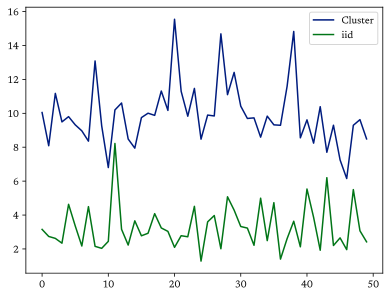

In [12]:
plt.plot(prediction_cluster_loss, label='Cluster')
plt.plot(prediction_iid_loss, label='iid')
plt.legend()

#### **Bar Plot**

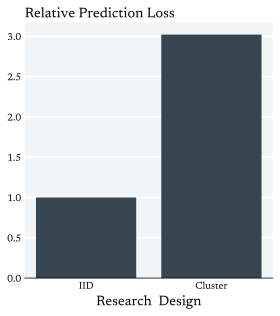

In [30]:
# Calculate means
mean_iid_loss = jnp.mean(jnp.array(prediction_iid_loss))
mean_cluster_loss = jnp.mean(jnp.array(prediction_cluster_loss))

# Prepare data for bar graph
labels = ['IID', 'Cluster']
means = [mean_iid_loss/mean_iid_loss, mean_cluster_loss/mean_iid_loss]

# Create bar graph
fig = plt.figure(dpi=300, tight_layout=True, figsize=(4, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

subtitle = 'Relative Prediction Loss'
ax.text(0., 1.02, s=subtitle, transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.bar(labels, means, color='#36454F')
plt.xlabel('Research  Design', size=14)
fig.savefig(figure_folders + 'high_variance.png')
plt.show()